<a href="https://colab.research.google.com/github/mshadabgithub/DNN/blob/main/Anomaly_Detection_For_Time_Based_Data_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [3]:
'''print(dataframe.shape)
print(dataframe[dataframe[140]==1].shape)
train_data_1 = dataframe[dataframe[140]==1]
train_data_0 = dataframe[dataframe[140]==0]'''
train_data_0 = dataframe.copy()

In [20]:
train_data_0.shape

(4998, 141)

In [4]:
# The last element contains the labels
#labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = train_data_0.iloc[:, 0:-2]

train_data, test_data = train_test_split(
    data, test_size=0.05, random_state=21
)

In [5]:
min_val = train_data.min()
max_val = train_data.max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

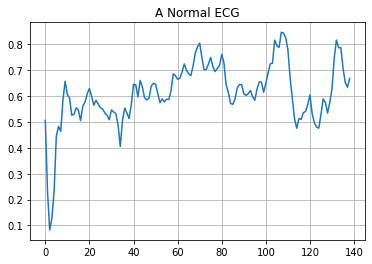

In [6]:
plt.grid()
plt.plot(np.arange(139), train_data[0])
plt.title("A Normal ECG")
plt.show()

In [7]:
print(train_data.shape)
train_data = tf.reshape(train_data, [train_data.shape[0], 1, train_data.shape[1]])
test_data = tf.reshape(test_data, [test_data.shape[0], 1, test_data.shape[1]])
print(train_data.shape)
print(test_data.shape)

(4748, 139)
(4748, 1, 139)
(250, 1, 139)


In [8]:
'''encoder_input = keras.Input(shape=(train_data.shape[1], train_data.shape[2]))
encoder1 = keras.layers.LSTM(64, return_sequences=True, activation="relu")(encoder_input)
encoder2 = keras.layers.LSTM(32, return_sequences=False, activation="relu")(tf.reshape(encoder1, [-1, 1, 64]))

#encoder_output = keras.layers.RepeatVector(train_data.shape[1])(encoder2)

encoder = keras.Model(encoder_input, encoder2, name="encoder")

decoder_input1 = keras.layers.LSTM(32, return_sequences=True, activation="relu")(tf.reshape(encoder2, [-1, 1, 32]))
decoder_output = keras.layers.LSTM(train_data.shape[2])(decoder_input1)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()'''
encoder_input = keras.Input(shape=(train_data.shape[1], train_data.shape[2]))
encoder1 = keras.layers.Dense(64, activation="relu")(encoder_input)
encoder2 = keras.layers.Dense(32, activation="relu")(encoder1)
encoder3 = keras.layers.Dense(2, activation="relu")(encoder2)
#encoder_output = keras.layers.RepeatVector(train_data.shape[1])(encoder2)

encoder = keras.Model(encoder_input, encoder3, name="encoder")

decoder_input1 = keras.layers.Dense(32, activation="relu")(encoder3)
decoder_input2 = keras.layers.Dense(64, activation="relu")(decoder_input1)
decoder_output = keras.layers.Dense(train_data.shape[2])(decoder_input2)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 139)]          0         
_________________________________________________________________
dense (Dense)                (None, 1, 64)             8960      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)             2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 2)              66        
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             96        
_________________________________________________________________
dense_4 (Dense)              (None, 1, 64)             2112      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 139)            

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

In [10]:
history = autoencoder.fit(train_data, train_data, 
                          epochs=5, 
                          batch_size=256,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/5
19/19 [==============================] - 1s 17ms/step - loss: 0.5031 - val_loss: 0.3257
Epoch 2/5
19/19 [==============================] - 0s 5ms/step - loss: 0.1924 - val_loss: 0.0989
Epoch 3/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0797 - val_loss: 0.0702
Epoch 4/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0681 - val_loss: 0.0659
Epoch 5/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0665 - val_loss: 0.0652


In [25]:
te_pred = encoder.predict(test_data).reshape(test_data.shape[0], 2)
te_pred = pd.DataFrame(te_pred)
te_pred.head()

,0,1
0,1.532225,3.167441
1,1.380467,2.925060
2,1.505830,3.075934
3,1.465062,3.102511
4,1.534061,3.221339


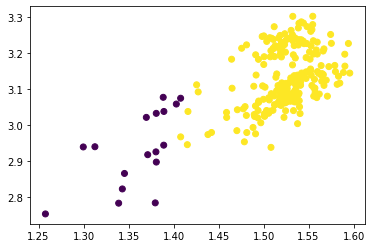

In [33]:
model_clus = DBSCAN(eps = 0.05, min_samples=10).fit(te_pred)
colors = model_clus.labels_
plt.scatter(te_pred[0], te_pred[1], c = colors)

In [36]:
te_pred['outlier_y_n'] = model_clus.labels_
te_pred.head()

,0,1,outlier_y_n
0,1.532225,3.167441,0
1,1.380467,2.925060,-1
2,1.505830,3.075934,0
3,1.465062,3.102511,0
4,1.534061,3.221339,0


In [35]:
outliers = te_pred[model_clus.labels_ == -1]
print(outliers)

            0         1
1    1.380467  2.925060
5    1.299736  2.938777
10   1.371324  2.917196
12   1.369789  3.021207
75   1.257661  2.752089
81   1.379705  2.782859
87   1.388552  3.077154
108  1.389114  2.943749
109  1.389309  3.037710
117  1.380823  3.032445
126  1.407905  3.074591
129  1.345517  2.864889
143  1.312654  2.939378
196  1.339043  2.782020
197  1.380887  2.896623
211  1.403123  3.058362
221  1.343136  2.821729


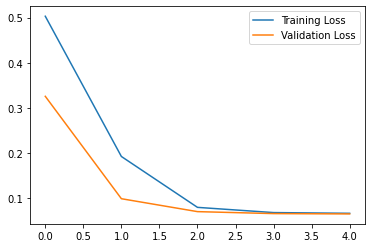

In [37]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

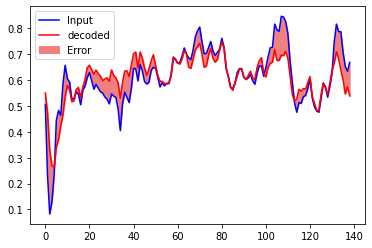

In [38]:
decoded_data = autoencoder(train_data).numpy()

plt.plot(train_data[0].numpy().flatten(), 'b')
plt.plot(decoded_data[0].flatten(), 'r')
plt.fill_between(np.arange(139), decoded_data[0].flatten(), train_data[0].numpy().flatten(), color='lightcoral')
plt.legend(labels=["Input", "decoded", "Error"])
plt.show()

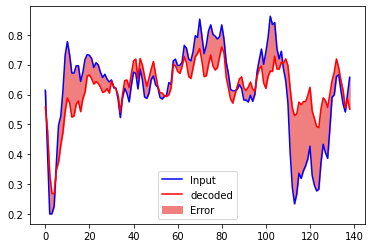

In [39]:
decoded_data = autoencoder(test_data).numpy()

plt.plot(test_data[0].numpy().flatten(), 'b')
plt.plot(decoded_data[0].flatten(), 'r')
plt.fill_between(np.arange(139), decoded_data[0].flatten(), test_data[0].numpy().flatten(), color='lightcoral')
plt.legend(labels=["Input", "decoded", "Error"])
plt.show()

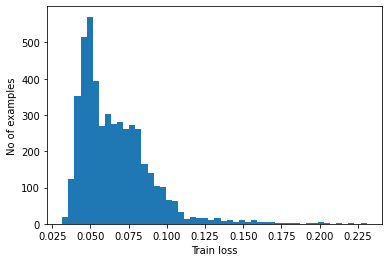

In [40]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss.numpy(), bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [41]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.089659736


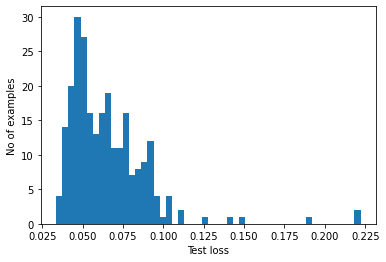

In [42]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss.numpy(), bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

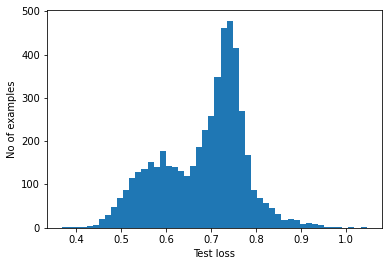

In [44]:
data_test = train_data_0.iloc[:, 0:-2]
test_1 = tf.reshape(data_test, [data_test.shape[0], 1, data_test.shape[1]])
decoded_1 = autoencoder.predict(test_1)
test_loss4_1 = tf.keras.losses.mae(decoded_1, test_1)

plt.hist(test_loss4_1.numpy(), bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()